In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Precision, Recall
import datetime
%load_ext tensorboard

## Data Preprocessing

In [3]:
raw_df = pd.read_csv("data/af2_dataset_training_labeled.csv.gz", index_col=0)
raw_df.head()

,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,...,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry,entry_index,y_Ligand
0,M,False,False,False,False,False,False,False,False,False,...,0,0.0,47,-0.0,-26.499001,-4.742,-35.189999,GEMI5_HUMAN,0,False
1,G,False,False,False,False,False,True,False,False,False,...,0,0.0,0,0.0,-25.158001,-1.342,-34.104000,GEMI5_HUMAN,1,False
2,Q,False,False,False,False,False,False,False,False,False,...,1,-0.0,-1,-0.0,-21.926001,-1.641,-32.175999,GEMI5_HUMAN,2,False
3,E,False,False,False,True,False,False,False,False,False,...,706,-0.1,705,-0.0,-22.073999,0.654,-29.171000,GEMI5_HUMAN,3,False
4,P,False,False,False,False,False,False,False,False,False,...,0,0.0,705,-0.2,-19.783001,2.670,-26.858999,GEMI5_HUMAN,4,False


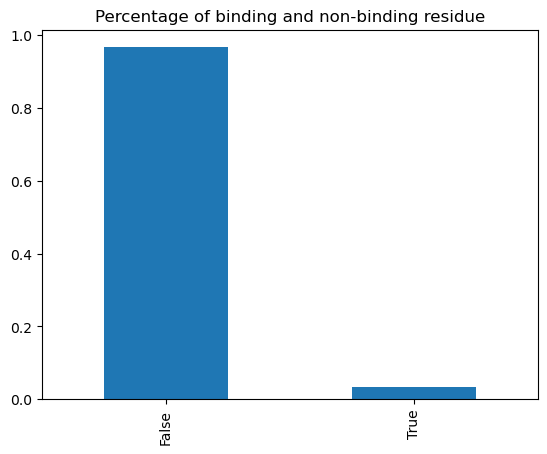

In [4]:
counts = raw_df['y_Ligand'].value_counts() / len(raw_df)
counts.plot.bar()
plt.title('Percentage of binding and non-binding residue')
plt.show()

In [5]:
# examine class imbalance
neg, pos = np.bincount(raw_df['y_Ligand'])
total = neg + pos
print('Total: {}\n Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Total: 497166
 Positive: 17254 (3.47% of total)



In [6]:
# clean dataset
cleaned_df = raw_df.copy()

# drop columns
# - annotation_sequence: covered by feat_[letter]
# - annotation_atomrec: don't know what exactly it is (almost same as annotation_sequence)
# - entry: object type causes input type problem for the model (bring it back in by one-hot encoding or label encoding if necessary)
cleaned_df.drop(['annotation_sequence', 'annotation_atomrec', 'entry'], axis=1, inplace=True)

# convert boolean columns into integer
cleaned_df[cleaned_df.select_dtypes(include='bool').columns] = cleaned_df.select_dtypes(include='bool').astype(int)

In [7]:
# split dataset into training and validation
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

y_train = np.array(train_df.pop('y_Ligand'))
bool_train_labels = y_train != 0
y_val = np.array(val_df.pop('y_Ligand'))
y_test = np.array(test_df.pop('y_Ligand'))

x_train = np.array(train_df)
x_val = np.array(val_df)
x_test = np.array(test_df)

In [8]:
# scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

## Preparing for model training
Code source: https://www.tensorflow.org/tensorboard/image_summaries

In [45]:
# function to train model (create, compile, and fit with validation dataset)
def train(model, x, y, x_val, y_val, lr, epochs, batchsz):
    log_dir = "logs/" + model.name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    print ("MODEL NAME:", model.name)
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', Precision(), Recall()],
    )
    return model.fit(
        x, 
        y,
        epochs=epochs,
        batch_size=batchsz,
        validation_data=(x_val, y_val),
        callbacks=[tensorboard_callback],
        verbose=1,
    )

## Model 1: simple NN with 3 layers 
Accuracy: 96.62%

In [17]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 42344), started 3 days, 17:13:47 ago. (Use '!kill 42344' to kill it.)

In [40]:
# define keras model
model1 = Sequential([
    Dense(12, input_dim=x_train.shape[1], activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
train_test_model(model1, x_train_scaled, y_train, x_val_scaled, y_val, lr=0.001, epochs=30, batchsz=50)

In [35]:
def tune_lr(model, step_size, num_steps, annealing_ratio, lr): 
    log_dir = "logs/" + model.name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    print ("MODEL NAME:", model.name)
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    model.compile(
          optimizer=optimizer,
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=["accuracy"],
    )
    for step in range(num_steps): 
        print('step:', step)
        if step > 0:
          lr = lr * annealing_ratio
        model.fit(
            x_train, 
            y_train,
            epochs=step_size,
            validation_data=(x_val, y_val),
            callbacks=[tensorboard_callback],
        verbose=1,
        )

In [37]:
model1_lrtuned = model1
tune_lr(model1_lrtuned, 5, 8, 0.5, 0.1)

MODEL NAME: sequential_1
Epoch 1/5
11653/11653 [==============================] - 17s 1ms/step - loss: 0.1515 - accuracy: 0.9653 - val_loss: 0.1531 - val_accuracy: 0.9652
Epoch 2/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1513 - val_accuracy: 0.9652
Epoch 3/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1510 - val_accuracy: 0.9652
Epoch 4/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1531 - val_accuracy: 0.9652
Epoch 5/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1515 - val_accuracy: 0.9652
Epoch 1/5
11653/11653 [==============================] - 17s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1512 - val_accuracy: 0.9652
Epoch 2/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.

## Grid search for better parameters
Using hparams dashboard

Source: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

In [23]:
EPOCHS = 10

# stop training when there are no improvements in validation score
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_precision',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [24]:
from tensorboard.plugins.hparams import api as hp

# define the hyperparameters to tune
LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([0.001, 0.01, 0.1]))
BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([16, 32, 64]))

# define metrics
METRIC_ACCURACY = hp.Metric('accuracy', display_name='Accuracy')
METRIC_PRECISION = hp.Metric('precision', display_name='Precision')
METRIC_RECALL = hp.Metric('recall', display_name='Recall')
METRICS = [METRIC_ACCURACY, METRIC_PRECISION, METRIC_RECALL]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[LEARNING_RATE, BATCH_SIZE],
        metrics=[METRIC_ACCURACY, METRIC_PRECISION, METRIC_RECALL],
    )

In [25]:
def train_test_model(hparams):
    model = Sequential([
        Dense(12, input_dim=x_train.shape[1], activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hparams[LEARNING_RATE]),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )
    
    model.fit(
        x_train, y_train, 
        epochs=EPOCHS, 
        callbacks=[early_stopping], 
        validation_data=(x_val, y_val), 
        verbose=0
    )
    metrics = model.evaluate(x_test, y_test)
    
    return metrics

In [32]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        metrics = train_test_model(hparams)
        _, accuracy, precision, recall = metrics
        tf.summary.scalar('accuracy', accuracy, step=1)
        tf.summary.scalar('precision', precision, step=1)
        tf.summary.scalar('recall', recall, step=1)

In [33]:
session_num = 0

# Perform the grid search
for bs in BATCH_SIZE.domain.values:
    for lr in LEARNING_RATE.domain.values:
        hparams = {
            BATCH_SIZE: bs,
            LEARNING_RATE: lr
        }
        
        run_name = 'run-%d' % session_num
        
        print('--- Starting trial:', run_name)
        print({h.name: hparams[h] for h in hparams})
        
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

--- Starting trial: run-0
{'batch_size': 16, 'learning_rate': 0.001}
3108/3108 [==============================] - 4s 1ms/step - loss: 0.1233 - accuracy: 0.9661 - precision: 0.6372 - recall: 0.0400
--- Starting trial: run-1
{'batch_size': 16, 'learning_rate': 0.01}
3108/3108 [==============================] - 4s 1ms/step - loss: 0.1252 - accuracy: 0.9655 - precision: 0.0000e+00 - recall: 0.0000e+00
--- Starting trial: run-2
{'batch_size': 16, 'learning_rate': 0.1}
3108/3108 [==============================] - 3s 1ms/step - loss: 0.1517 - accuracy: 0.9655 - precision: 0.0000e+00 - recall: 0.0000e+00
--- Starting trial: run-3
{'batch_size': 32, 'learning_rate': 0.001}
3108/3108 [==============================] - 4s 1ms/step - loss: 0.1231 - accuracy: 0.9665 - precision: 0.6679 - recall: 0.0540
--- Starting trial: run-4
{'batch_size': 32, 'learning_rate': 0.01}
3108/3108 [==============================] - 4s 1ms/step - loss: 0.1264 - accuracy: 0.9655 - precision: 0.0000e+00 - recall: 0.0000

#### Results:

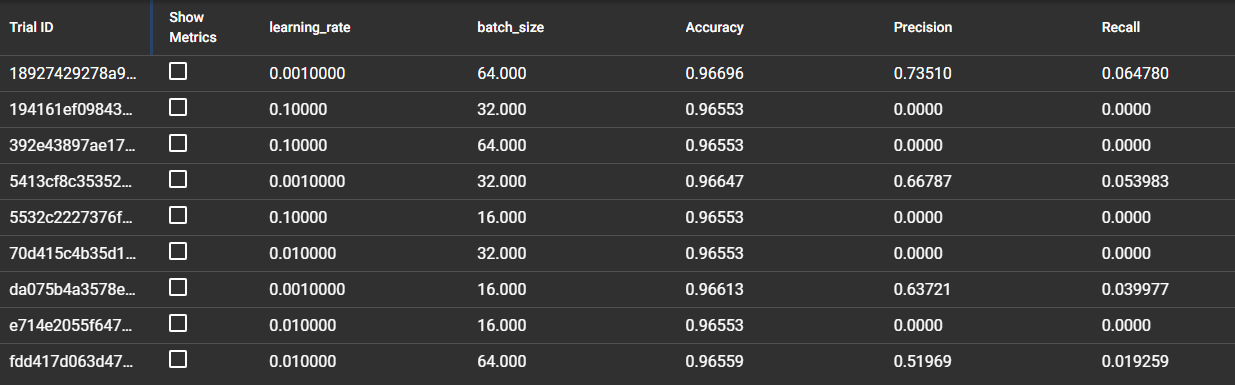

In [34]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 139920), started 19:01:37 ago. (Use '!kill 139920' to kill it.)

## Addressing low precision & recall
Guess: due to class imbalance?

In [38]:
# solution 1: undersampling
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')
x_under, y_under = undersample.fit_resample(x_train, y_train)

In [46]:
train(model1, x_under, y_under, x_val, y_val, lr=0.001, epochs=30, batchsz=64)

MODEL NAME: sequential_16
Epoch 1/30
344/344 [==============================] - 3s 6ms/step - loss: 0.6300 - accuracy: 0.6306 - precision: 0.6172 - recall: 0.6877 - val_loss: 0.5914 - val_accuracy: 0.5693 - val_precision: 0.0621 - val_recall: 0.7878
Epoch 2/30
344/344 [==============================] - 2s 5ms/step - loss: 0.5713 - accuracy: 0.6877 - precision: 0.6521 - recall: 0.8046 - val_loss: 0.5892 - val_accuracy: 0.5687 - val_precision: 0.0643 - val_recall: 0.8207
Epoch 3/30
344/344 [==============================] - 2s 5ms/step - loss: 0.5554 - accuracy: 0.7007 - precision: 0.6626 - recall: 0.8175 - val_loss: 0.5789 - val_accuracy: 0.5953 - val_precision: 0.0676 - val_recall: 0.8112
Epoch 4/30
344/344 [==============================] - 2s 5ms/step - loss: 0.5459 - accuracy: 0.7074 - precision: 0.6717 - recall: 0.8113 - val_loss: 0.5486 - val_accuracy: 0.6270 - val_precision: 0.0708 - val_recall: 0.7829
Epoch 5/30
344/344 [==============================] - 2s 5ms/step - loss: 0.53

In [47]:
model1.evaluate(x_test, y_test)

3108/3108 [==============================] - 4s 1ms/step - loss: 0.5514 - accuracy: 0.6803 - precision: 0.0796 - recall: 0.7838


[0.5514184236526489,
 0.6803004741668701,
 0.07962293177843094,
 0.7837759256362915]

In [53]:
from sklearn.metrics import confusion_matrix

under_pred_prob = model1.predict(x_test)
threshold = 0.5
under_pred = (under_pred_prob > threshold).astype(int)
confusion_matrix(y_test, under_pred)

3108/3108 [==============================] - 2s 766us/step


array([[64959, 31048],
       [  741,  2686]], dtype=int64)